### Celda 0: Sanity check
Imprime `hello world` para validar el entorno del notebook.

In [23]:
print("hello world")

hello world


### Celda 1: Versi?n de PyTorch y GPU
Muestra versi?n de PyTorch y disponibilidad de CUDA.

In [24]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.10.0.dev20251105+cu128
True


### Celda 2: Instalaci?n opcional Lightning
Comando comentado para instalar `pytorch-lightning` si no est? presente.

In [25]:
#pip install pytorch-lightning


### Celda 3: Instalaci?n opcional metric-learning
Comando comentado para `pytorch-metric-learning`.

In [26]:
#pip install pytorch-metric-learning


### Celda 4: Instalacion opcional XGBoost / Plyer
Comandos comentados para instalar XGBoost y Plyer (notificaciones).

In [27]:
#pip install xgboost
#pip install plyer

### Celda 5: Imports y configuraci?n global
Carga librer?as, fija device, limita VRAM al 90% y activa `cudnn.benchmark`.

In [28]:
# ================================================================
# NOTEBOOK: Siamese Triplet + FC + XGBoost + Embedding visuals per epoch
# ================================================================
# 0) IMPORTS
# ================================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.backends.cudnn as cudnn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.miners import TripletMarginMiner

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ajustes de visualizacion
sns.set()
plt.rcParams["figure.figsize"] = (9,6)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    torch.cuda.set_per_process_memory_fraction(0.9, device=0)
    torch.cuda.empty_cache()
    print("VRAM limitada al 90% para este proceso")
cudnn.benchmark = True

try:
    from plyer import notification as _notification
except Exception:
    _notification = None

def notify(title, message, timeout=8):
    if _notification is None:
        print(f"[NOTIFY] {title}: {message}")
        return
    try:
        _notification.notify(title=title, message=message, timeout=timeout)
    except Exception as e:
        print(f"[NOTIFY-FAIL] {title}: {message} ({e})")


Device: cuda
VRAM limitada al 90% para este proceso


### Celda 6: Datos y DataLoaders
Define transforms, datasets ImageFolder y DataLoaders con workers/pin_memory.

In [29]:
# ================================================================
# 1) DATA TRANSFORMS + DATASET
# ================================================================
DATASET_ROOT = r"dataset_split"

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATASET_ROOT, "val"),   transform=test_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"),  transform=test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

batch_size = 32
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True )
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True )
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True )

print("Clases detectadas:", class_names)
print(f"num_workers={num_workers}, batch_size={batch_size}")


Clases detectadas: ['Abutilon Indicum', 'Aloe barbadensis miller', 'Calotropis gigantea', 'Canna indica', 'Cissus quadrangularis', 'Curcuma longa', 'Eclipta prostrate', 'Eichhornia Crassipes', 'Hibiscus Rosasinensis', 'Ixora coccinea', 'Justica adhatoda', 'Murraya koenigii', 'Ocimum tenuiflorum', 'Ouretlanata', 'Phyllanthus amarus', 'Ricinus communis', 'Senna Atriculata', 'Sesbania grandiflora', 'Trifolium Repens', 'Ziziphus mauritiana']
num_workers=0, batch_size=32


### Celda 7: Backbone siamesa
ResNet50 con proyecci?n a 128 dimensiones.

In [16]:
# ================================================================
# 2) SIAMESE NETWORK
# ================================================================
class SiameseBackbone(nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone().to(device)

### Celda 8: Entrenamiento Triplet con Lightning
Define m?dulo Lightning, callbacks, AMP y manejo de OOM en `fit`.

In [17]:
# ================================================================
# 3) PYTORCH LIGHTNING TRAINER PARA TRIPLET LOSS
# ================================================================
class TripletLightning(pl.LightningModule):
    def __init__(self, model, lr=1e-4, margin=0.2):
        super().__init__()
        self.model = model
        self.miner = TripletMarginMiner(margin=margin, type_of_triplets="semihard")
        self.loss_func = TripletMarginLoss(margin=margin)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self(imgs)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.loss_func(embeddings, labels, hard_pairs)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        embeddings = self(imgs)
        hard_pairs = self.miner(embeddings, labels)
        loss = self.loss_func(embeddings, labels, hard_pairs)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
        return opt

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="siamese-best")
]

lightning_model = TripletLightning(siamese, lr=1e-4, margin=0.2)
use_amp = torch.cuda.is_available()

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed" if use_amp else 32,
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,
    log_every_n_steps=10,
    callbacks=callbacks
)

try:
    trainer.fit(lightning_model, train_loader, val_loader)
except RuntimeError as e:
    if torch.cuda.is_available() and "out of memory" in str(e).lower():
        torch.cuda.empty_cache()
        print("WARN: OOM durante triplet training. Reduce batch_size o sube accumulate_grad_batches.")
    else:
        raise

torch.save(siamese.state_dict(), "siamese_triplet.pth")
print("Modelo siames guardado como siamese_triplet.pth")
notify("Triplet training", "Entrenamiento finalizado y modelo guardado")


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 5060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.ht

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\pytorch_lightning\utilities\_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 24: 100%|██████████| 55/55 [03:06<00:00,  0.29it/s, v_num=2, train_loss=0.000, val_loss=0.0194]    
Modelo siames guardado como siamese_triplet.pth


### Celda 9: Clasificador FC sobre embeddings
Backbone congelado + capa lineal, entrenamiento con AMP y manejo de OOM.

In [18]:
# ================================================================
# 4) CLASIFICADOR FC (BACKBONE CONGELADO)
# ================================================================
class Classifier(nn.Module):
    def __init__(self, backbone, emb_size, num_classes):
        super().__init__()
        for p in backbone.parameters():
            p.requires_grad = False

        self.backbone = backbone
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        with torch.no_grad():
            emb = self.backbone(x)
        return self.fc(emb)

classifier = Classifier(siamese, 128, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scaler = torch.cuda.amp.GradScaler(enabled=device=="cuda")

epochs_fc = 30
for epoch in range(epochs_fc):
    classifier.train()
    running_loss = 0
    for img, lbl in train_loader:
        img, lbl = img.to(device, non_blocking=True), lbl.to(device, non_blocking=True)
        optimizer.zero_grad()
        try:
            with torch.cuda.amp.autocast(enabled=device=="cuda"):
                out = classifier(img)
                loss = criterion(out, lbl)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        except RuntimeError as e:
            if device == "cuda" and "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                print("WARN: OOM en batch FC, se salta. Reduce batch_size si persiste.")
                continue
            else:
                raise
        running_loss += loss.item()
        del loss, out
    scheduler.step()
    torch.cuda.empty_cache()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

# Guardar clasificador FC
torch.save(classifier.state_dict(), "classifier_fc.pth")
print("Clasificador FC guardado como classifier_fc.pth")
notify("Clasificador FC", f"Entrenamiento completado ({epochs_fc} epocas)")


C:\Users\chori\AppData\Local\Temp\ipykernel_34800\1176536894.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device=="cuda")
C:\Users\chori\AppData\Local\Temp\ipykernel_34800\1176536894.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device=="cuda"):


Epoch 1 - Loss: 2.4799
Epoch 2 - Loss: 1.5105
Epoch 3 - Loss: 0.9320
Epoch 4 - Loss: 0.5983
Epoch 5 - Loss: 0.4190
Epoch 6 - Loss: 0.3224
Epoch 7 - Loss: 0.2576
Epoch 8 - Loss: 0.2053
Epoch 9 - Loss: 0.1686
Epoch 10 - Loss: 0.1550
Epoch 11 - Loss: 0.1492
Epoch 12 - Loss: 0.1178
Epoch 13 - Loss: 0.1136
Epoch 14 - Loss: 0.1068
Epoch 15 - Loss: 0.1011
Epoch 16 - Loss: 0.0915
Epoch 17 - Loss: 0.0972
Epoch 18 - Loss: 0.0835
Epoch 19 - Loss: 0.0877
Epoch 20 - Loss: 0.0787
Epoch 21 - Loss: 0.0692
Epoch 22 - Loss: 0.0725
Epoch 23 - Loss: 0.0708
Epoch 24 - Loss: 0.0714
Epoch 25 - Loss: 0.0745
Epoch 26 - Loss: 0.0701
Epoch 27 - Loss: 0.0707
Epoch 28 - Loss: 0.0606
Epoch 29 - Loss: 0.0666
Epoch 30 - Loss: 0.0714
Clasificador FC guardado como classifier_fc.pth


### Celda 10: Evaluaci?n del clasificador FC
Calcula accuracy y F1 macro en el set de test.

In [19]:
# ================================================================
# 5) EVALUACION DEL CLASIFICADOR FC
# ================================================================
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = out.argmax(1).cpu().numpy()
            preds.extend(p)
            labels.extend(y.numpy())

    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return acc, f1, labels, preds

acc, f1, y_true, y_pred = evaluate(classifier, test_loader)

print("Accuracy FC:", acc)
print("F1-score FC:", f1)


Accuracy FC: 0.9898734177215189
F1-score FC: 0.991039067315663


### Celda 10.1: Matriz de confusi?n del clasificador FC (checkpoint)
Usa el checkpoint `classifier_fc_triplet.pth` para evaluar en test y graficar la matriz de confusi?n.

==== Eval FC (checkpoint classifier_fc_triplet.pth) ====
Accuracy: 0.9899 | Macro-F1: 0.9910
Reporte:                         precision    recall  f1-score   support

       Abutilon Indicum     0.9615    0.9615    0.9615        26
Aloe barbadensis miller     1.0000    1.0000    1.0000        23
    Calotropis gigantea     1.0000    0.9412    0.9697        17
           Canna indica     0.9583    1.0000    0.9787        23
  Cissus quadrangularis     1.0000    1.0000    1.0000        21
          Curcuma longa     1.0000    0.9412    0.9697        17
      Eclipta prostrate     0.9412    1.0000    0.9697        32
   Eichhornia Crassipes     1.0000    1.0000    1.0000        31
  Hibiscus Rosasinensis     1.0000    1.0000    1.0000        18
         Ixora coccinea     1.0000    1.0000    1.0000        18
       Justica adhatoda     1.0000    1.0000    1.0000        15
       Murraya koenigii     1.0000    1.0000    1.0000        19
     Ocimum tenuiflorum     1.0000    1.0000    1.000

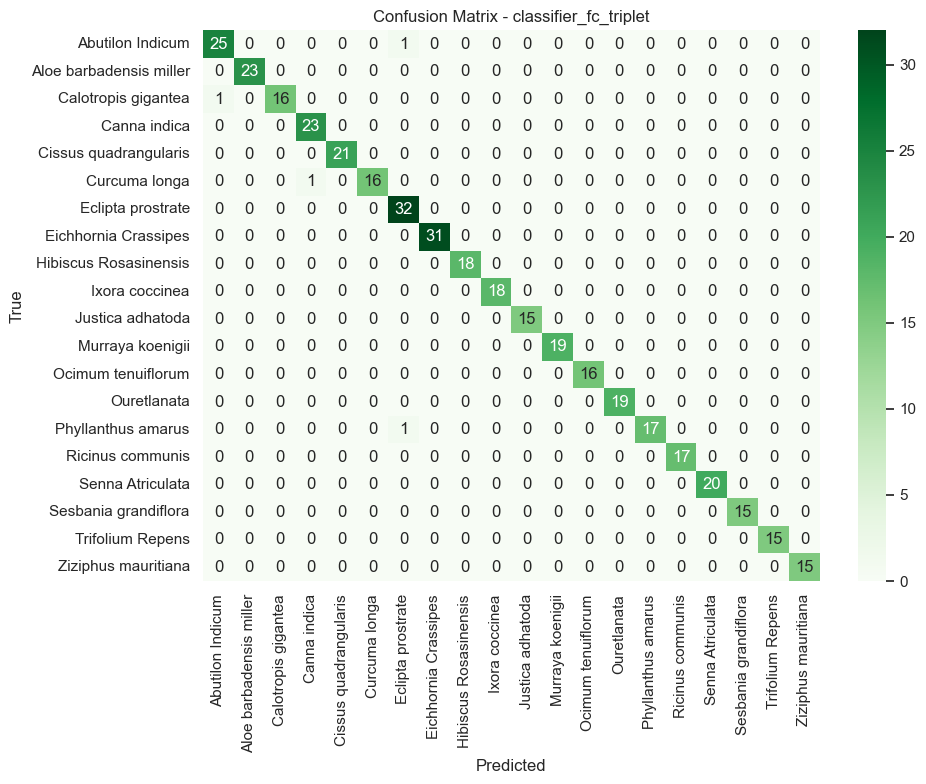

Matriz de confusion guardada en results_fc\confmat_classifier_fc_triplet.png


In [54]:
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

ckpt_path = Path("classifier_fc_triplet.pth")
backbone_ckpt = Path("siamese_triplet_backbone.pth")

# Reconstruir backbone y clasificador desde los checkpoints
backbone_eval = SiameseBackbone(embedding_size=128).to(device)
if backbone_ckpt.exists():
    backbone_eval.load_state_dict(torch.load(backbone_ckpt, map_location=device))
classifier_eval = Classifier(backbone_eval, 128, num_classes).to(device)
classifier_eval.load_state_dict(torch.load(ckpt_path, map_location=device))
classifier_eval.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = classifier_eval(images)
        preds = outputs.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

acc_ckpt = accuracy_score(all_labels, all_preds)
f1_ckpt = f1_score(all_labels, all_preds, average="macro")
cm_ckpt = confusion_matrix(all_labels, all_preds)
report_ckpt = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

print("==== Eval FC (checkpoint classifier_fc_triplet.pth) ====")
print(f"Accuracy: {acc_ckpt:.4f} | Macro-F1: {f1_ckpt:.4f}")
print("Reporte:" + report_ckpt)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_ckpt, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - classifier_fc_triplet")
confmat_path = Path("results_fc")
confmat_path.mkdir(exist_ok=True, parents=True)
confmat_file = confmat_path / "confmat_classifier_fc_triplet.png"
plt.tight_layout()
plt.savefig(confmat_file, dpi=300)
plt.show()
print(f"Matriz de confusion guardada en {confmat_file}")


### Celda 11: Extracci?n de embeddings
Genera embeddings y etiquetas para train/test usando el backbone.

In [20]:
# ================================================================
# 6) EXTRAER EMBEDDINGS (PARA XGBOOST)
# ================================================================
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())

    return np.vstack(all_emb), np.hstack(all_lbl)

train_emb, train_lbl = extract_embeddings(siamese, train_loader)
test_emb,  test_lbl  = extract_embeddings(siamese, test_loader)

print("Embeddings shape:", train_emb.shape)

Embeddings shape: (1751, 128)


### Celda 12: Visualizaci?n de embeddings
Reduce a 2D con PCA/TSNE y grafica por clase.

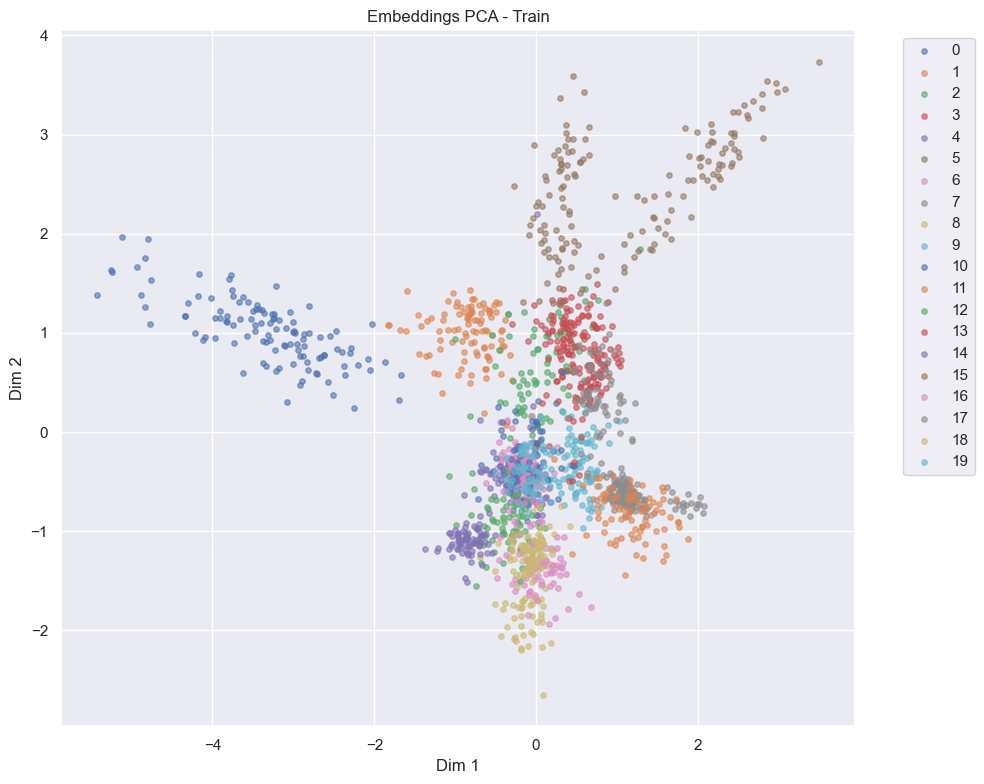

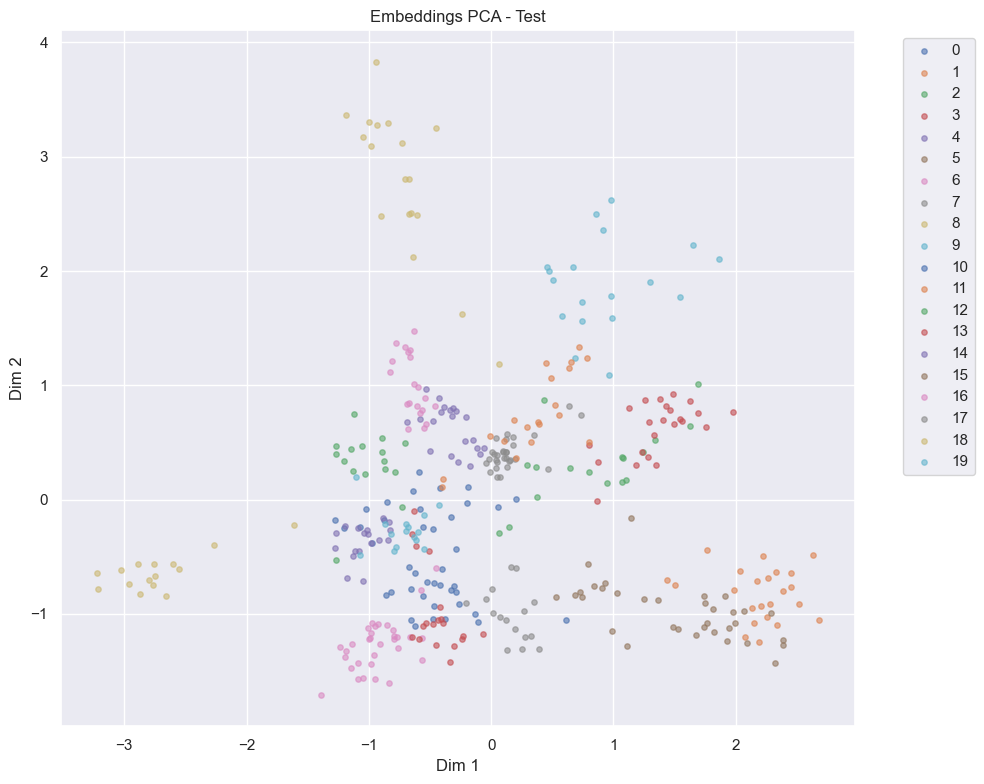

In [21]:
# ================================================================
# 6.1) VISUALIZAR EMBEDDINGS EN 2D
# ================================================================
def plot_embeddings(embeddings, labels, method="pca", title="Embeddings 2D"):
    """
    embeddings: np.array (N, embedding_dim)
    labels: np.array (N,)
    method: "pca" o "tsne"
    """
    if method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    else:
        reducer = PCA(n_components=2)
        
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    num_classes = len(np.unique(labels))
    for c in range(num_classes):
        idx = labels == c
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=str(c), alpha=0.6, s=15)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

# Visualizar embeddings de entrenamiento
plot_embeddings(train_emb, train_lbl, method="pca", title="Embeddings PCA - Train")

# Visualizar embeddings de test
plot_embeddings(test_emb, test_lbl, method="pca", title="Embeddings PCA - Test")

### Celda 13: Clasificaci?n con XGBoost
Entrena XGBoost sobre embeddings (usa GPU si est? disponible).

WARN: XGBoost sin soporte GPU; cambiando a CPU (hist/predictor=auto)


c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\xgboost\training.py:199: UserWarning: [00:51:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Evaluacion XGBoost (CPU) ====
Accuracy: 0.9797 | Macro-F1: 0.9821
Reporte:                         precision    recall  f1-score   support

       Abutilon Indicum     0.9583    0.8846    0.9200        26
Aloe barbadensis miller     1.0000    1.0000    1.0000        23
    Calotropis gigantea     1.0000    1.0000    1.0000        17
           Canna indica     1.0000    1.0000    1.0000        23
  Cissus quadrangularis     0.9545    1.0000    0.9767        21
          Curcuma longa     1.0000    1.0000    1.0000        17
      Eclipta prostrate     0.9143    1.0000    0.9552        32
   Eichhornia Crassipes     1.0000    0.9355    0.9667        31
  Hibiscus Rosasinensis     1.0000    1.0000    1.0000        18
         Ixora coccinea     1.0000    1.0000    1.0000        18
       Justica adhatoda     0.9375    1.0000    0.9677        15
       Murraya koenigii     1.0000    0.9474    0.9730        19
     Ocimum tenuiflorum     0.9412    1.0000    0.9697        16
          

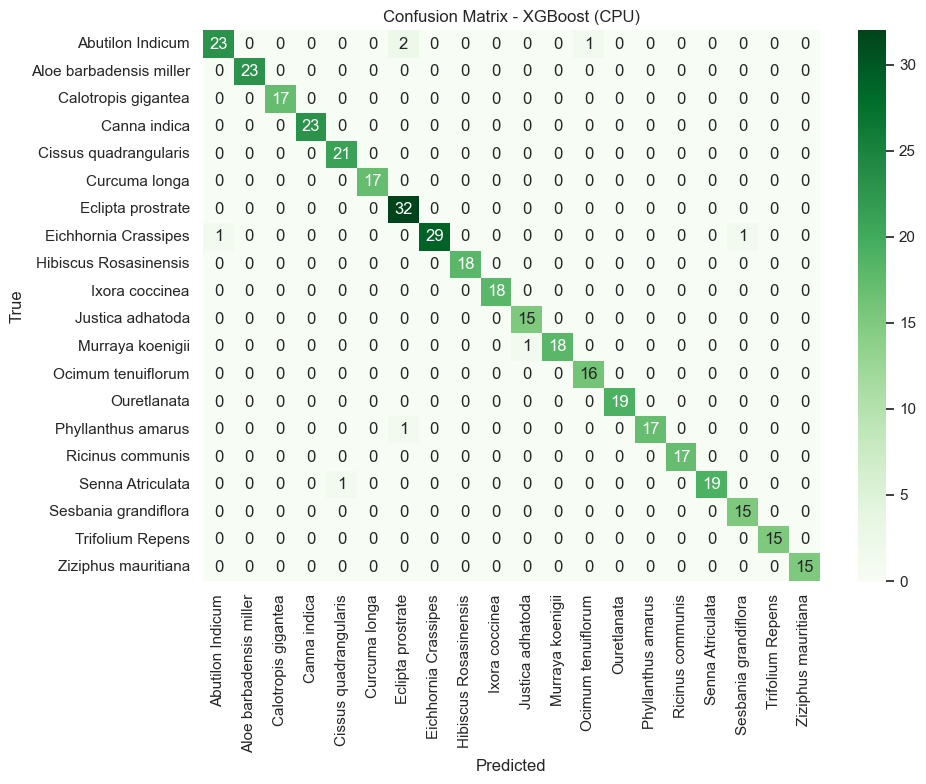

Matriz de confusion guardada en results_xgb\confmat_xgb.png
Predicciones guardadas en results_xgb\preds_xgb.csv
Metricas guardadas en results_xgb\metrics_xgb.csv


In [43]:
# ================================================================
# 7) XGBOOST PARA CLASIFICAR EMBEDDINGS
# ================================================================
from pathlib import Path
import pandas as pd
from sklearn.metrics import classification_report
from xgboost.core import XGBoostError

RESULTS_DIR_XGB = Path("results_xgb")
RESULTS_DIR_XGB.mkdir(exist_ok=True, parents=True)
LABEL_NAMES = class_names

def build_xgb_params(use_gpu: bool):
    params = dict(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='mlogloss'
    )
    if use_gpu:
        params.update(tree_method="gpu_hist", predictor="gpu_predictor")
    else:
        params.update(tree_method="hist", predictor="auto")
    return params

use_gpu = torch.cuda.is_available()
params = build_xgb_params(use_gpu)

try:
    xgb = XGBClassifier(**params)
    xgb.fit(train_emb, train_lbl)
except XGBoostError as e:
    msg = str(e).lower()
    if use_gpu and ("gpu_hist" in msg or "gpu_predictor" in msg):
        print("WARN: XGBoost sin soporte GPU; cambiando a CPU (hist/predictor=auto)")
        params = build_xgb_params(False)
        xgb = XGBClassifier(**params)
        xgb.fit(train_emb, train_lbl)
        use_gpu = False
    else:
        raise

xgb_preds = xgb.predict(test_emb)

acc_xgb = accuracy_score(test_lbl, xgb_preds)
f1_xgb  = f1_score(test_lbl, xgb_preds, average="macro")
cm_xgb = confusion_matrix(test_lbl, xgb_preds)
report_xgb = classification_report(test_lbl, xgb_preds, target_names=LABEL_NAMES, digits=4)
backend = "GPU" if use_gpu else "CPU"

print(f"==== Evaluacion XGBoost ({backend}) ====")
print(f"Accuracy: {acc_xgb:.4f} | Macro-F1: {f1_xgb:.4f}")
print("Reporte:" + report_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - XGBoost ({backend})")
confmat_path = RESULTS_DIR_XGB / "confmat_xgb.png"
plt.tight_layout(); plt.savefig(confmat_path, dpi=300); plt.show()
print(f"Matriz de confusion guardada en {confmat_path}")

preds_df = pd.DataFrame({
    "filepath": [p for p,_ in test_dataset.samples][:len(test_lbl)],
    "true_label": [LABEL_NAMES[i] for i in test_lbl],
    "pred_label": [LABEL_NAMES[i] for i in xgb_preds],
})
preds_df["correct"] = preds_df["true_label"] == preds_df["pred_label"]
preds_csv = RESULTS_DIR_XGB / "preds_xgb.csv"
preds_df.to_csv(preds_csv, index=False)

metrics_df = pd.DataFrame([{"accuracy": acc_xgb, "macro_f1": f1_xgb, "backend": backend}])
metrics_csv = RESULTS_DIR_XGB / "metrics_xgb.csv"
metrics_df.to_csv(metrics_csv, index=False)

print(f"Predicciones guardadas en {preds_csv}")
print(f"Metricas guardadas en {metrics_csv}")
notify("XGBoost", f"{backend}: Acc {acc_xgb:.3f} | F1 {f1_xgb:.3f}")


WARN: XGBoost sin soporte GPU; cambiando a CPU (hist/predictor=auto)


c:\Users\chori\anaconda3\envs\EXAMEN\lib\site-packages\xgboost\training.py:199: UserWarning: [00:51:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Evaluacion XGBoost (CPU) ====
Accuracy: 0.9797 | Macro-F1: 0.9821
Reporte:                         precision    recall  f1-score   support

       Abutilon Indicum     0.9583    0.8846    0.9200        26
Aloe barbadensis miller     1.0000    1.0000    1.0000        23
    Calotropis gigantea     1.0000    1.0000    1.0000        17
           Canna indica     1.0000    1.0000    1.0000        23
  Cissus quadrangularis     0.9545    1.0000    0.9767        21
          Curcuma longa     1.0000    1.0000    1.0000        17
      Eclipta prostrate     0.9143    1.0000    0.9552        32
   Eichhornia Crassipes     1.0000    0.9355    0.9667        31
  Hibiscus Rosasinensis     1.0000    1.0000    1.0000        18
         Ixora coccinea     1.0000    1.0000    1.0000        18
       Justica adhatoda     0.9375    1.0000    0.9677        15
       Murraya koenigii     1.0000    0.9474    0.9730        19
     Ocimum tenuiflorum     0.9412    1.0000    0.9697        16
          

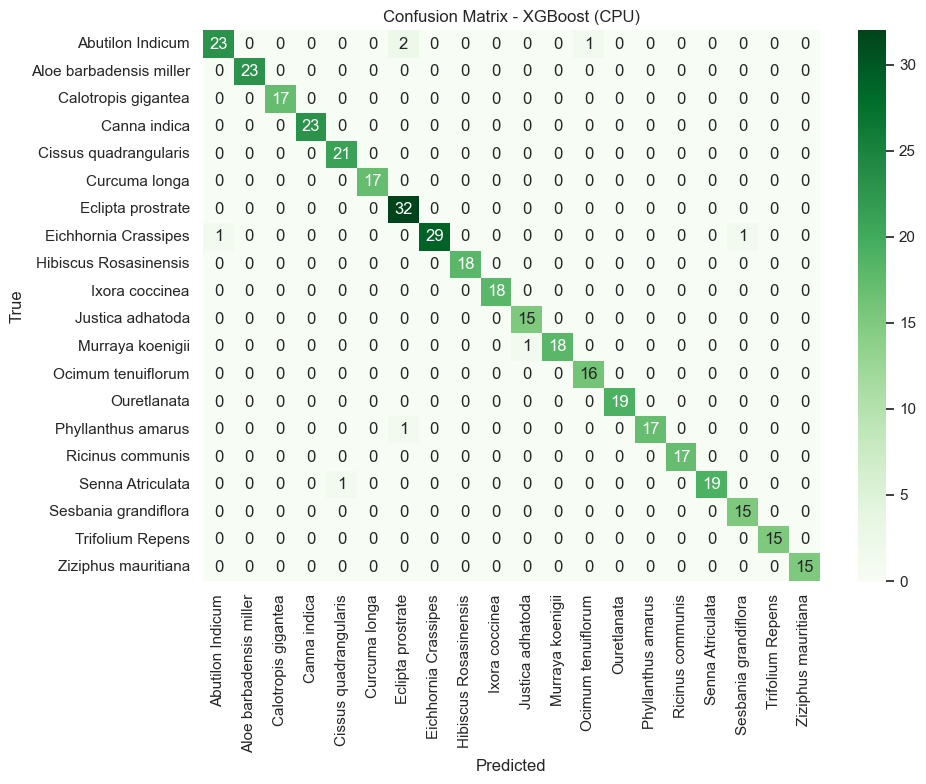

Matriz de confusion guardada en results_xgb\confmat_xgb.png
Predicciones guardadas en results_xgb\preds_xgb.csv
Metricas guardadas en results_xgb\metrics_xgb.csv


In [44]:
# ================================================================
# 7) XGBOOST PARA CLASIFICAR EMBEDDINGS
# ================================================================
from xgboost.core import XGBoostError

RESULTS_DIR_XGB = Path("results_xgb")
RESULTS_DIR_XGB.mkdir(exist_ok=True, parents=True)

def build_xgb_params(use_gpu: bool):
    params = dict(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='mlogloss'
    )
    if use_gpu:
        params.update(tree_method="gpu_hist", predictor="gpu_predictor")
    else:
        params.update(tree_method="hist", predictor="auto")
    return params

use_gpu = torch.cuda.is_available()
params = build_xgb_params(use_gpu)

try:
    xgb = XGBClassifier(**params)
    xgb.fit(train_emb, train_lbl)
except XGBoostError as e:
    msg = str(e).lower()
    if use_gpu and ("gpu_hist" in msg or "gpu_predictor" in msg):
        print("WARN: XGBoost sin soporte GPU; cambiando a CPU (hist/predictor=auto)")
        params = build_xgb_params(False)
        xgb = XGBClassifier(**params)
        xgb.fit(train_emb, train_lbl)
        use_gpu = False
    else:
        raise

xgb_preds = xgb.predict(test_emb)

acc_xgb = accuracy_score(test_lbl, xgb_preds)
f1_xgb  = f1_score(test_lbl, xgb_preds, average="macro")
cm_xgb = confusion_matrix(test_lbl, xgb_preds)
report_xgb = classification_report(test_lbl, xgb_preds, target_names=LABEL_NAMES, digits=4)
backend = "GPU" if use_gpu else "CPU"

print(f"==== Evaluacion XGBoost ({backend}) ====")
print(f"Accuracy: {acc_xgb:.4f} | Macro-F1: {f1_xgb:.4f}")
print("Reporte:" + report_xgb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", xticklabels=LABEL_NAMES, yticklabels=LABEL_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion Matrix - XGBoost ({backend})")
confmat_path = RESULTS_DIR_XGB / "confmat_xgb.png"
plt.tight_layout(); plt.savefig(confmat_path, dpi=300); plt.show()
print(f"Matriz de confusion guardada en {confmat_path}")

preds_df = pd.DataFrame({
    "filepath": [p for p,_ in test_dataset.samples][:len(test_lbl)],
    "true_label": [LABEL_NAMES[i] for i in test_lbl],
    "pred_label": [LABEL_NAMES[i] for i in xgb_preds],
})
preds_df["correct"] = preds_df["true_label"] == preds_df["pred_label"]
preds_csv = RESULTS_DIR_XGB / "preds_xgb.csv"
preds_df.to_csv(preds_csv, index=False)

metrics_df = pd.DataFrame([{"accuracy": acc_xgb, "macro_f1": f1_xgb, "backend": backend}])
metrics_csv = RESULTS_DIR_XGB / "metrics_xgb.csv"
metrics_df.to_csv(metrics_csv, index=False)

print(f"Predicciones guardadas en {preds_csv}")
print(f"Metricas guardadas en {metrics_csv}")
notify("XGBoost", f"{backend}: Acc {acc_xgb:.3f} | F1 {f1_xgb:.3f}")


# 8) MATRIZ DE CONFUSION XGBOOST
cm = confusion_matrix(test_lbl, xgb_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusion - XGBoost")
plt.xlabel("Prediccion")
plt.ylabel("Verdad")
plt.show()


In [45]:
# Confusion matrix ya generada en la celda XGBoost anterior.

### Celda 15: Guardado de modelos
Guarda pesos del backbone, FC y XGBoost.

In [46]:
# ================================================================
# 9) GUARDAR MODELOS
# ================================================================
torch.save(siamese.state_dict(), "siamese_triplet_backbone.pth")
torch.save(classifier.state_dict(), "classifier_fc_triplet.pth")
xgb.save_model("xgboost_triplet.json")
print("✅ Modelos guardados en la carpeta del notebook")

✅ Modelos guardados en la carpeta del notebook


### Celda 16: Script de inferencia final
Carga modelos guardados, extrae embeddings de test y reporta m?tricas.

In [47]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

# ------------------------------
# Configuración
# ------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = r"dataset_split"  # Cambia según tu ruta
batch_size = 32

# ------------------------------
# Transformaciones del test set
# ------------------------------
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(DATASET_ROOT, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# ------------------------------
# Reconstruir la red siamesa
# ------------------------------
class SiameseBackbone(torch.nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.backbone = models.resnet50(weights="DEFAULT")
        self.backbone.fc = torch.nn.Linear(self.backbone.fc.in_features, embedding_size)

    def forward(self, x):
        return self.backbone(x)

siamese = SiameseBackbone(embedding_size=128).to(device)
siamese.load_state_dict(torch.load("siamese_triplet_backbone.pth", map_location=device))
siamese.eval()

# ------------------------------
# Extraer embeddings del test set
# ------------------------------
def extract_embeddings(model, loader):
    model.eval()
    all_emb, all_lbl = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            all_emb.append(emb)
            all_lbl.append(y.numpy())
    return np.vstack(all_emb), np.hstack(all_lbl)

test_emb, test_lbl = extract_embeddings(siamese, test_loader)

# ------------------------------
# Cargar XGBoost
# ------------------------------
xgb = XGBClassifier()
xgb.load_model("xgboost_triplet.json")
xgb_preds = xgb.predict(test_emb)

# ------------------------------
# Métricas finales
# ------------------------------
acc = accuracy_score(test_lbl, xgb_preds)
precision = precision_score(test_lbl, xgb_preds, average="macro")
f1 = f1_score(test_lbl, xgb_preds, average="macro")
cm = confusion_matrix(test_lbl, xgb_preds)

print("🎯 XGBoost Test Accuracy :", acc)
print("⚡ XGBoost Test Precision:", precision)
print("🔥 XGBoost Test F1-score :", f1)
print("Matriz de confusión (normalizada):")
print(cm)


🎯 XGBoost Test Accuracy : 0.979746835443038
⚡ XGBoost Test Precision: 0.9821670486376369
🔥 XGBoost Test F1-score : 0.9821288046367712
Matriz de confusión (normalizada):
[[23  0  0  0  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 18  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0  

### Celda 17: Funciones de b?squeda por similitud
Utilidades para embeddings de un folder, top-k por distancia coseno y visualizaci?n.

In [48]:
# ================================================================
# 10) BUSCADOR DE SIMILITUD - TOP 10 IMÁGENES MÁS CERCANAS
# ================================================================
from PIL import Image
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import os
import numpy as np

# --- 10.1 Extraer embeddings de un folder (base de búsqueda) ---
def compute_embeddings_for_folder(model, folder_path, transform, device="cuda"):
    model.eval()
    embeddings = []
    paths = []

    # Recorremos TODAS las subcarpetas (clases)
    for root, dirs, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)

            try:
                img = Image.open(fpath).convert("RGB")
            except:
                continue

            x = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = model(x).cpu().numpy().flatten()

            embeddings.append(emb)
            paths.append(fpath)

    return np.array(embeddings), paths

# --- 10.2 TOP-10 similares ---
def top_k_similar(model, input_image_path, db_embeddings, db_paths, transform, k=10, device="cuda"):
    model.eval()

    img = Image.open(input_image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model(x).cpu().numpy().reshape(1, -1)

    # Distancias cosine
    dist = cosine_distances(emb, db_embeddings)[0]
    idx = np.argsort(dist)[:k]

    return [(db_paths[i], dist[i]) for i in idx]


# --- 10.3 Mostrar resultados visualmente ---
def show_similarity_results(input_path, results):
    plt.figure(figsize=(15, 8))

    # Mostrar input
    plt.subplot(2, 6, 1)
    plt.imshow(Image.open(input_path))
    plt.title("INPUT")
    plt.axis("off")

    # Mostrar top 10
    for i, (path, d) in enumerate(results):
        plt.subplot(2, 6, i+2)
        plt.imshow(Image.open(path))
        plt.title(f"{i+1} | dist={d:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


### Celda 18: Construcci?n de base de embeddings
Extrae embeddings para la base de b?squeda desde `train`.

In [51]:
# Folder que servira como base (puedes usar train/val/test)
BASE_FOLDER = os.path.join(DATASET_ROOT, "train")

# Reconstruir el clasificador FC desde el checkpoint guardado
backbone_ckpt = "siamese_triplet_backbone.pth"
classifier_ckpt = "classifier_fc_triplet.pth"

# Cargar backbone siamesa
siamese_enc = SiameseBackbone(embedding_size=128).to(device)
siamese_enc.load_state_dict(torch.load(backbone_ckpt, map_location=device))

# Construir clasificador y cargar pesos
classifier_loaded = Classifier(siamese_enc, 128, num_classes).to(device)
classifier_loaded.load_state_dict(torch.load(classifier_ckpt, map_location=device), strict=False)
classifier_loaded.eval()

# Usar solo el backbone del clasificador para embeddings
class ClassifierBackbone(torch.nn.Module):
    def __init__(self, clf):
        super().__init__()
        self.clf = clf
    def forward(self, x):
        with torch.no_grad():
            return self.clf.backbone(x)

encoder = ClassifierBackbone(classifier_loaded).to(device).eval()

# Extraer embeddings de la base usando el backbone del clasificador
db_embeddings, db_paths = compute_embeddings_for_folder(
    model=encoder,
    folder_path=BASE_FOLDER,
    transform=test_transform,
    device=device
)

print("Base de embeddings cargada (classifier_fc_triplet):", db_embeddings.shape)
print(DATASET_ROOT)
notify("Base de embeddings", f"Listo: {db_embeddings.shape}")


Base de embeddings cargada (classifier_fc_triplet): (1751, 128)
dataset_split


### Celda 19: Consulta de similitud
Ejemplo de top-10 similares para una imagen de entrada.

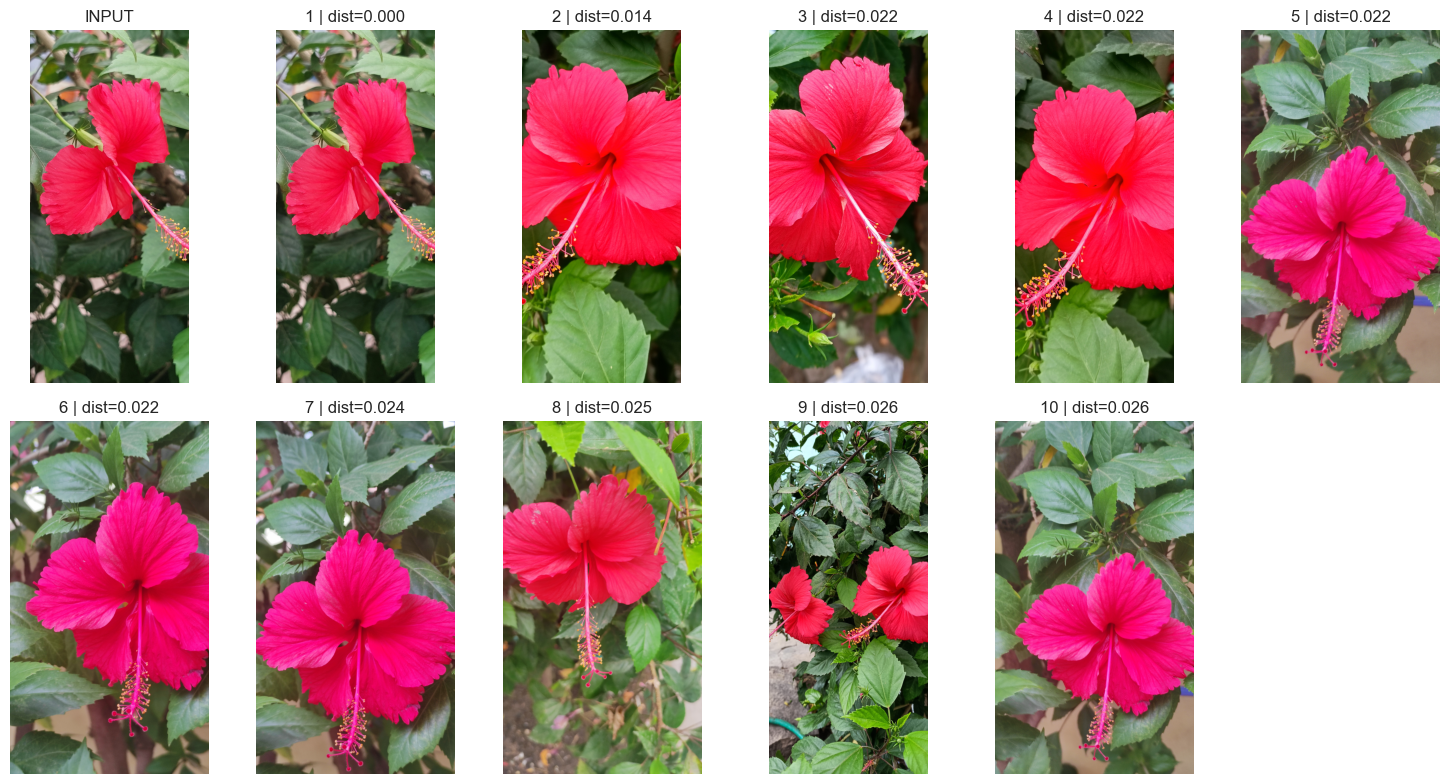

In [57]:
input_image = r"C:\Users\chori\OneDrive\Documentos\ULIMA\2025-2\deep learning\examen final\deep\dataset_split\train\Hibiscus Rosasinensis\aaa (1).jpg"
results = top_k_similar(
    model=encoder,
    input_image_path=input_image,
    db_embeddings=db_embeddings,
    db_paths=db_paths,
    transform=test_transform,
    device=device
)

show_similarity_results(input_image, results)
